<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/hidden_RWNN_mnist_test/mnist_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
    This notebook was taken from https://github.com/NesterukSergey/hidden-networks/blob/master/demos/mnist.ipynb
    And was only modified to predict 0s instead of all classes of MNIST digits
"""

from __future__ import print_function
import argparse
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd

from tqdm import tqdm

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

In [0]:
class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, k, weights_init, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.weights_init = weights_init

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        # initialize the weights
        if self.weights_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.weight, mode="fan_in", nonlinearity="relu")
        elif self.weights_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.weight, mode="fan_in", nonlinearity="relu")
        elif self.weights_init == 'xavier_normal':
          nn.init.xavier_normal_(self.weight)
        else:
          nn.init.uniform_(self.weight)
        
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

class SupermaskLinear(nn.Linear):
    def __init__(self, *args, k, weights_init, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.weights_init = weights_init

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        # initialize the weights
        if self.weights_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.weight, mode="fan_in", nonlinearity="relu")
        elif self.weights_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.weight, mode="fan_in", nonlinearity="relu")
        elif self.weights_init == 'xavier_normal':
          nn.init.xavier_normal_(self.weight)
        else:
          nn.init.uniform_(self.weight)

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

# NOTE: not used here but we use NON-AFFINE Normalization!
# So there is no learned parameters for your nomralization layer.
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

In [0]:
class Net(nn.Module):
    def __init__(self, k, init='kaiming_normal'):
        super(Net, self).__init__()
        self.conv1 = SupermaskConv(1, 32, 3, 1, bias=False, k=k, weights_init=init)
        self.conv2 = SupermaskConv(32, 64, 3, 1, bias=False, k=k, weights_init=init)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = SupermaskLinear(9216, 128, bias=False, k=k, weights_init=init)
        self.fc2 = SupermaskLinear(128, 1, bias=False, k=k, weights_init=init)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.sigmoid(x)
        return output

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
data_path = './data'

if not os.path.exists(data_path):
  os.mkdir(data_path)

In [0]:
batch_size = 64
test_batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(data_path, 'mnist'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(data_path, 'mnist'), train=False, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

In [0]:
class Denormalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.demean = [-mean / std]
        self.std = std
        self.destd = [1 / std]
        self.inplace = inplace

    def __call__(self, tensor):
        tensor = TF.normalize(tensor, self.demean, self.destd, self.inplace)
        # clamp to get rid of numerical errors
        return torch.clamp(tensor, 0.0, 1.0)

In [0]:
def show_batch(dataloader):
    fig, ax = plt.subplots(1, dataloader.batch_size, sharex=True, sharey=True, figsize=(20, 10))
    img_batch, label = iter(dataloader).next()
    label = (label > 0).float()
    denormalize = Denormalize((0.1307), (0.3081))  
    
    print(label)
    for i in range(dataloader.batch_size):                                
        ax[i].imshow(transforms.ToPILImage()(denormalize(img_batch[i, :, :, :])))

tensor([1., 1., 1., 1., 1., 1., 1., 0.])


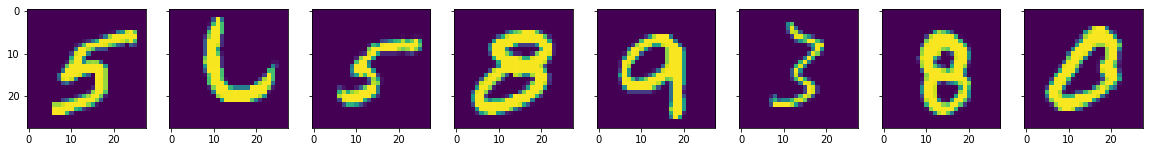

In [0]:
show_batch(train_loader)

In [0]:
def train(model, device, train_loader, optimizer, criterion, epoch, verbose=False):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = (target > 0).float()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss

        if verbose:
          if batch_idx % 750 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))
              
    return train_loss / len(train_loader.dataset)


def test(model, device, criterion, test_loader):
    true_labels = []
    predictions = [] # labels
    outputs = [] # probabilities

    model.eval()
    test_loss = 0
    # correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = (target > 0).float()
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target)
            output_value = output.detach().cpu().numpy()
            outputs.append(output_value)
            pred = (output_value > 0.5).astype(float)
            pred = pred.reshape(pred.shape[:-1])
            predictions.extend(pred)
            true_labels.extend(target.detach().cpu().numpy())
            # correct += pred.eq(target.view_as(pred)).sum().item()

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    outputs = np.array(outputs)

    test_loss /= len(test_loader.dataset)
    test_accuracy = np.sum(np.equal(predictions, true_labels)) / len(true_labels)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        # test_loss, correct, len(test_loader.dataset),
        # 100. * correct / len(test_loader.dataset)))
    
    return test_loss.item(), test_accuracy

In [0]:
model = Net(k=0.5, init='kaiming_normal').to(device)

# NOTE: only pass the parameters where p.requires_grad == True to the optimizer! Important!
optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.1,
    momentum=0.9,
    weight_decay=0.0005,
)

criterion = nn.BCELoss().to(device)
scheduler = CosineAnnealingLR(optimizer, T_max=14)

In [0]:
def run_model(k, init, num_epochs):
  model = Net(k=k, init=init).to(device)

  # NOTE: only pass the parameters where p.requires_grad == True to the optimizer! Important!
  optimizer = optim.SGD(
      [p for p in model.parameters() if p.requires_grad],
      lr=0.1,
      momentum=0.9,
      weight_decay=0.0005,
  )

  criterion = nn.BCELoss().to(device)
  scheduler = CosineAnnealingLR(optimizer, T_max=14)

  train_losses = []
  test_losses = []
  test_acc = []

  for epoch in tqdm(range(num_epochs)):
      train_loss = train(model, device, train_loader, optimizer, criterion, epoch, verbose=False)
      test_loss, test_accuracy = test(model, device, criterion, test_loader)
      scheduler.step()

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      test_acc.append(test_accuracy)

  fig, ax = plt.subplots(1, 2, figsize=(12, 8))

  ax[0].plot(range(num_epochs), train_losses, label='Train loss')
  ax[0].plot(range(num_epochs), test_losses, label='Test loss')
  ax[0].set_title('Losses')
  ax[0].legend()

  ax[1].plot(range(num_epochs), test_acc)
  ax[1].set_title('Accuracy (on test)')

  plt.show()

  print('k: ', k, '  init: ', init)
  print('Test loss: ', test_losses[-1])
  print('Train accuracy: ', test_acc[-1])

  if 'accuracies' in globals():
    accuracies[init][k] = test_acc[-1]





  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduct

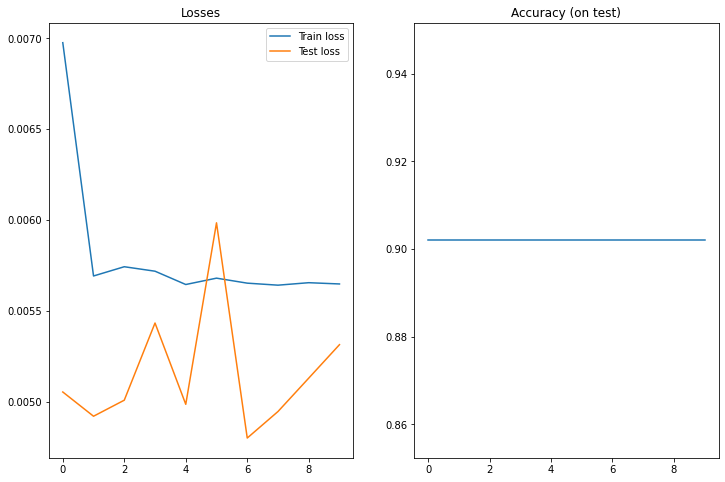

k:  0.5   init:  kaiming_uniform
Test loss:  0.005314496345818043
Train accuracy:  0.902


In [0]:
run_model(0.5, 'kaiming_uniform', num_epochs=10)

In [0]:
accuracies

,kaiming_normal,kaiming_uniform,xavier_normal,NaN
0.1,NaN,NaN,NaN,NaN
0.3,NaN,0.098,NaN,NaN
0.5,NaN,0.902,NaN,NaN
0.7,NaN,NaN,NaN,NaN
0.9,NaN,NaN,NaN,NaN
